# Import Libraries

In [1]:
# To store data
import pandas as pd

# To connect to postgresql
import psycopg2

# To get plots
import matplotlib.pyplot as plt

# To get nicer plots
import seaborn as sns

/home/jm/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Connection

In [2]:
def conn():
    #conn = psycopg2.connect("user='postgres' host='192.168.0.2' password='geheim' dbname=tankerkoenig16")
    conn = psycopg2.connect("user='root' host='localhost' password='geheim' dbname=root")
    return conn.cursor()

# Explore A Single Gas Stations Diesel Price

In [13]:
cur = conn()
cur.execute('select stid from gas_station_information_history limit 10')
cur.fetchall()

[('f1fe439f-3843-49e4-b1e2-59c6da4538e9',),
 ('315d83df-93c7-4ccd-950b-3869a5cd1845',),
 ('38b5c955-c54f-49c9-bb89-297c3755bae1',),
 ('00060293-0001-4444-8888-acdc00000001',),
 ('00061393-0001-4444-8888-acdc00000001',),
 ('00061404-0003-4444-8888-acdc00000003',),
 ('aa6d9976-e9ae-4478-486e-097e86c1e5fe',),
 ('a90afd8b-87ee-447e-392e-e957b2d4cd25',),
 ('8da97d50-540e-4fdb-d032-7f443a9869a0',),
 ('0aa73064-1b21-43e3-878e-4d00278bfecd',)]

In [15]:
cur = conn()
cur.execute("select diesel, date from gas_station_information_history where stid='315d83df-93c7-4ccd-950b-3869a5cd1845'")
data = cur.fetchall()

columns = ['diesel', 'date']
pr = pd.DataFrame(data, columns=columns)
pr['date'] = pd.to_datetime(pr['date'], utc=True,).apply(lambda x: x.date())
pr.set_index('date', inplace=True)

pr = pr.groupby(pr.index).agg({'diesel':'mean'})
print('Shape: {}'.format(pr.shape))
pr.head()

Shape: (782, 1)


,diesel
date,
2016-05-01,1089.000000
2016-05-02,1079.000000
2016-05-03,1080.666667
2016-05-04,1087.000000
2016-05-05,1084.000000


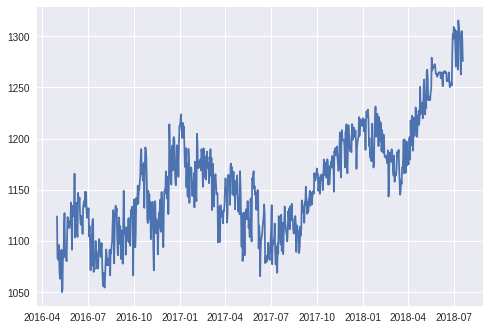

In [4]:
plt.plot(pr)
plt.show()

In [5]:
def test_stationarity(timeseries, n=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(n, center=True, min_periods=1).mean()
    rolstd = timeseries.rolling(n, center=True, min_periods=1).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

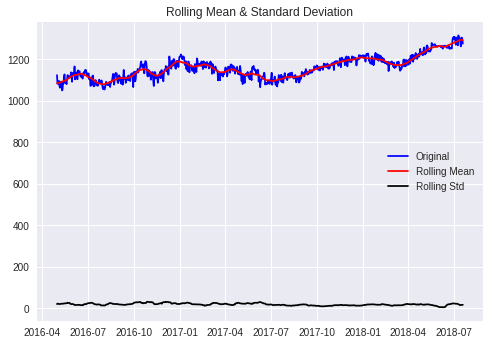

In [6]:
test_stationarity(pr, n=30)

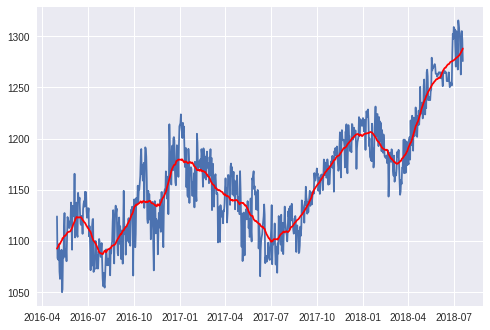

In [7]:
moving_avg = pr.rolling(50, center=True, min_periods=1).mean()
plt.plot(pr)
plt.plot(moving_avg, color='red')
plt.show()

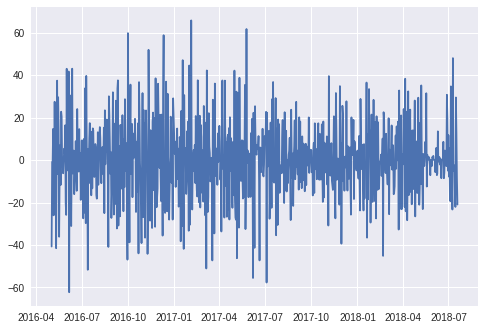

In [9]:
pr_shift = pr - pr.shift()
plt.plot(pr_shift)
plt.show()

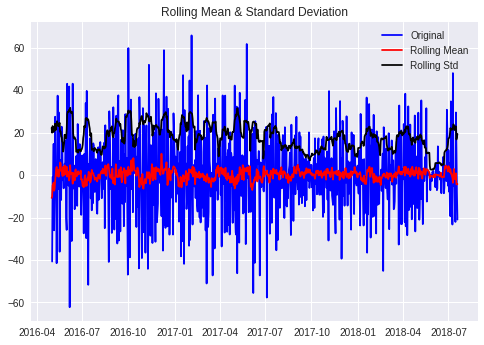

In [10]:
test_stationarity(pr_shift)

In [11]:
pr.index

Index([2016-05-01, 2016-05-02, 2016-05-03, 2016-05-04, 2016-05-05, 2016-05-06,
       2016-05-07, 2016-05-08, 2016-05-09, 2016-05-10,
       ...
       2018-07-10, 2018-07-11, 2018-07-12, 2018-07-13, 2018-07-14, 2018-07-15,
       2018-07-16, 2018-07-17, 2018-07-18, 2018-07-19],
      dtype='object', name='date', length=808)

In [12]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

/home/jm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
pr.to_csv('gasolin.csv', index=False, header=False)

In [27]:
#Step 1 Load Data
n = 10
X_train, y_train, X_test, y_test = lstm.load_data('gasolin.csv', n, True)
print('Shape X_train:\t{}'.format(X_train.shape))
print('Shape y_train:\t{}'.format(y_train.shape))
print('Shape X_test:\t{}'.format(X_test.shape))
print('Shape y_test:\t{}'.format(y_test.shape))

Shape X_train:	(718, 10, 1)
Shape y_train:	(718,)
Shape X_test:	(80, 10, 1)
Shape y_test:	(80,)


In [32]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(input_dim=1, output_dim=100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(300, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='rmsprop')

In [33]:
#Step 3 Train the model
model.fit(X_train,
          y_train,
          batch_size=50,
          nb_epoch=50,
          validation_split=0.15)

Train on 610 samples, validate on 108 samples
Epoch 1/50
610/610 [==============================] - 8s 13ms/step - loss: 0.0027 - val_loss: 5.1526e-04
Epoch 2/50
610/610 [==============================] - 4s 7ms/step - loss: 4.9068e-04 - val_loss: 5.1436e-04
Epoch 3/50
610/610 [==============================] - 5s 8ms/step - loss: 5.0469e-04 - val_loss: 0.0010
Epoch 4/50
610/610 [==============================] - 5s 8ms/step - loss: 5.7608e-04 - val_loss: 4.0271e-04
Epoch 5/50
610/610 [==============================] - 5s 8ms/step - loss: 4.2381e-04 - val_loss: 8.4657e-04
Epoch 6/50
610/610 [==============================] - 5s 8ms/step - loss: 4.6896e-04 - val_loss: 3.3602e-04
Epoch 7/50
610/610 [==============================] - 5s 9ms/step - loss: 3.7550e-04 - val_loss: 4.4557e-04
Epoch 8/50
610/610 [==============================] - 5s 9ms/step - loss: 3.6743e-04 - val_loss: 4.5391e-04
Epoch 9/50
610/610 [==============================] - 6s 9ms/step - loss: 4.0170e-04 - val_loss: 

yo


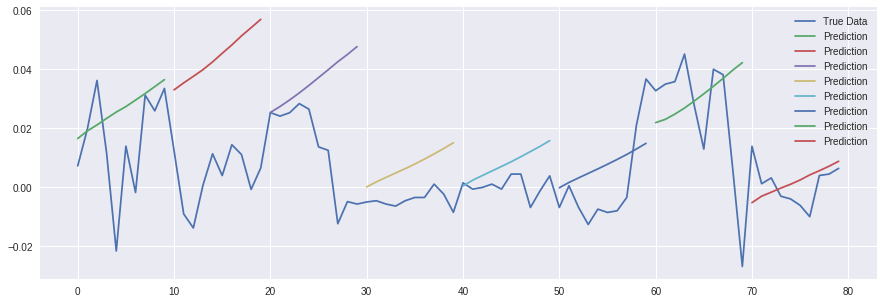

In [41]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 10, 10)
lstm.plot_results_multiple(predictions, y_test, 10)

In [ ]:
cur = conn()
n = 10000000
cur.execute('select stid, date, e5, e10, diesel from gas_station_information_history limit {}'.format(n))

In [ ]:
data = {}
while True:
    row = cur.fetchone()
    if not row:
        break
        
    if row[0] in data.keys():
        if row[1].date() in data[row[0]].keys():
            data[row[0]][row[1].date()][0] += row[2]
            data[row[0]][row[1].date()][1] += row[3]
            data[row[0]][row[1].date()][2] += row[4]
            data[row[0]][row[1].date()][3] += 1
        else:
            data[row[0]] = {row[1].date(): [row[2], row[3], row[4], 1]}
    else:
        data[row[0]] = {row[1].date(): [row[2], row[3], row[4], 1]}

In [46]:
import numpy as np

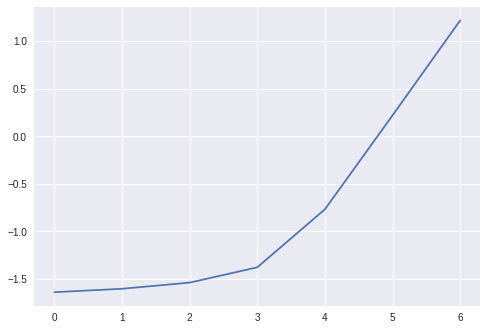

In [52]:
x, y = zip(*np.log10(pd.DataFrame([[1,0.023], [10,0.025], [100,0.029], [1000,0.042],[10000,0.171], [100000,1.66], [1000000,16.5], [10000000,]])).values)
plt.plot(x, y)
plt.show()